## 🧠 Alzheimer's Disease Classification
## The data in total consists of 6400 images.

## VGG16 Model

### Libraries

In [23]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn
from tensorflow.keras import backend as K
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation, Conv2D, MaxPooling2D, LeakyReLU
from tensorflow.keras.callbacks import TensorBoard
import pickle
from PIL import Image
import time
import os
from PIL import Image
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# from sklearn.model_selection import KFold

start = time.time()

## Model Parameter/Hyper Parameter for preloaded vgg16 model

In [2]:
dim = (176,208)               # input image dimensions                                              (176,208)
test_split_percent = .1       # % of total data for testing                                         .1
validation_split_percent = .2 # % of total data for validation                                      .2
zoom = [.99,1.01]             # zoom range (for a fixed zoom put the same value in both parameters)[.99,1.01]
bright_range = [.8,1.2]       # brightness range                                                    [.8,1.2] 
layers_unlocked = True        # unlock the imported pre-training layers?                            False  
lr = 0.0001                   # learning rate for optimizer                                         0.0001
batch = 20                    # batch size for model fitting                                        20
eps = 5                      # number of epochs to run                                             50
momentum = .9                 # momentum of SGD                                                     .9

save_model_name = "val%2d_epochs%d"%(validation_split_percent*100,eps)   # automatically generate a model save name
print(save_model_name)

val20_epochs5


### Loading the data

In [3]:
# This section uses the ImageDataGenerator and flow_from_directory functions to sort the images by label
#actual dimensions 176x208x1

# introduced zoom, blew up the image of the brain itself, and brightness range to adjust for different brightness
train_dr = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,fill_mode='constant',cval=0,
                                                           brightness_range=bright_range,zoom_range=zoom,
                                                           data_format='channels_last',zca_whitening=False)

train_data_gen = train_dr.flow_from_directory(directory="/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train/",target_size=dim,
                                              batch_size=5000)

# Change to zoom = [1,1] to use normal test data
test_dr = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,fill_mode='constant',cval=0,zoom_range=[1,1],
                                                          data_format='channels_last') 
test_data_gen = test_dr.flow_from_directory(directory="/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test/",target_size=dim,batch_size=5000,
                                           shuffle = False)

Found 5121 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


In [5]:
train_data,train_labels =  train_data_gen.next()
test_data,test_labels = test_data_gen.next()
total_data = np.concatenate((train_data,test_data))
total_labels = np.concatenate((train_labels,test_labels))
print(total_data.shape)
print(total_labels.shape)

(1400, 176, 208, 3)
(1400, 4)


### Train-Test Data split

In [6]:

initial_split = test_split_percent+validation_split_percent
test_val_split = test_split_percent/initial_split

# split into training and (test + validation)
train_data, test_val_data, train_labels, test_val_labels = train_test_split(total_data,total_labels,
                                                                            test_size=initial_split)

# split (test + validation) into test and validation sets
test_data, val_data, test_labels, val_labels = train_test_split(test_val_data,test_val_labels,
                                                                test_size=test_val_split)

print('train: ',train_data.shape)
print('validation',val_data.shape)
print('test',test_data.shape)

train:  (979, 176, 208, 3)
validation (141, 176, 208, 3)
test (280, 176, 208, 3)


## Data Dimensions

In [7]:
print(train_data.shape)
print(train_labels.shape)
print(val_data.shape)
print(val_labels.shape)
print(test_data.shape)
print(test_labels.shape)

(979, 176, 208, 3)
(979, 4)
(141, 176, 208, 3)
(141, 4)
(280, 176, 208, 3)
(280, 4)


### Data Visualization

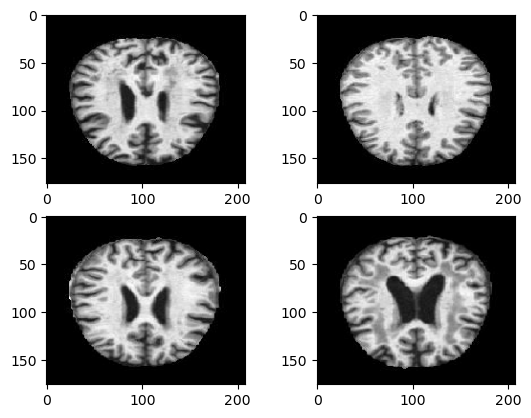

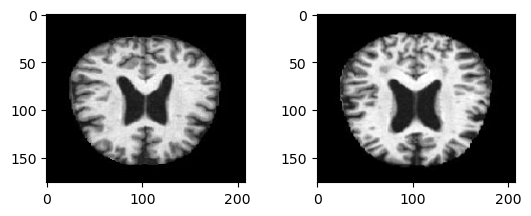

In [8]:
plt.subplot(221)
plt.imshow(train_data[1,:,:,:])
plt.subplot(222)
plt.imshow(train_data[2,:,:,:])
plt.subplot(223)
plt.imshow(val_data[3,:,:,:])
plt.subplot(224)
plt.imshow(val_data[4,:,:,:])
plt.show()
plt.subplot(221)
plt.imshow(test_data[5,:,:,:])
plt.subplot(222)
plt.imshow(test_data[154,:,:,:])

### Loading the pre-loaded model

In [9]:
vg_model = load_model("/kaggle/input/valsplit20-epochs50-testacc98h5/valsplit20_epochs50_testacc98.h5")

### Create Model
## or to load a model, skip down to "Load Model", then you can either continue training that model by skipping the next cell, or jump to "Evaluate Model"

### Model Architecture of the preloaded model

In [10]:
# import pre-trained VGG16 model

# vg_model = tf.keras.applications.vgg16.VGG16(include_top=False,input_shape=(dim[0],dim[1],3), pooling = 'max') #added pooling

## IF YOU LOADED A MODEL AND WANT TO CONTINUE TRAINING, comment above, uncomment below
# vg_model = vg_model(include_top=False,input_shape=(dim[0],dim[1],3), pooling = 'max') #added pooling

# retrain some of the convolutional layers deep in the model, but not the fully connected layers at the end

# vg_model.get_layer('block1_conv1').trainable = layers_unlocked
# vg_model.get_layer('block1_conv2').trainable = layers_unlocked
# vg_model.get_layer('block2_conv1').trainable = layers_unlocked
# vg_model.get_layer('block2_conv2').trainable = layers_unlocked
# vg_model.get_layer('block3_conv1').trainable = layers_unlocked
# vg_model.get_layer('block3_conv2').trainable = layers_unlocked
# vg_model.get_layer('block3_conv3').trainable = layers_unlocked
# vg_model.get_layer('block4_conv1').trainable = layers_unlocked
# vg_model.get_layer('block4_conv2').trainable = layers_unlocked
# vg_model.get_layer('block4_conv3').trainable = layers_unlocked

## always leave last layer trainable ##
# vg_model.get_layer('block5_conv1').trainable = False
# vg_model.get_layer('block5_conv2').trainable = False
# vg_model.get_layer('block5_conv3').trainable = False

## Add new trainable FC layers ##
# flat = Flatten()(vg_model.output)
# fc1 = Dense(1024,activation='relu', kernel_initializer='he_uniform')(flat) # put in kernel initializer he-uniform
# dp1 = Dropout(0.25)(fc1)                                                   # changed dropout here from .5
# output = Dense(4,activation='softmax')(dp1)                                # changed to sigmoid from softmax
# vg_model = Model(inputs=vg_model.inputs, outputs=output)

### Model Compilation and Training

In [12]:
# compile the model
#changed from tf.keras.optimizers.Adam(learning_rate=.0001) to SGD+nest.+momentum

# opt = tf.keras.optimizers.SGD(learning_rate=lr, momentum=momentum, nesterov=True,name='SGD') 

# vg_model.compile(optimizer=opt, loss=tf.keras.losses.categorical_crossentropy, metrics=['accuracy'])

In [13]:
# model_history = vg_model.fit(train_data,train_labels,validation_data=(val_data,val_labels),
#                              epochs=eps,batch_size=batch, shuffle=True) #changed batch size from 15
# scores = vg_model.evaluate(train_data, train_labels)
# print("Accuracy: %.2f%%" %(scores[1]*100))

In [11]:
vg_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 176, 208, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 176, 208, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 176, 208, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 88, 104, 64)       0         
                                                                 
 block2_conv1 (Conv2D)       (None, 88, 104, 128)      73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 88, 104, 128)      147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 44, 52, 128)       0     

### Performance Evaluation

In [14]:
train_scores = vg_model.evaluate(train_data, train_labels)
val_scores = vg_model.evaluate(val_data,val_labels)
test_scores = vg_model.evaluate(test_data, test_labels)

print('Train Accuracy: %.2f%%'%(train_scores[1]*100))
print('Validation Accuracy: %.2f%%'%(val_scores[1]*100))
print('Test Accuracy: %.2f%%'%(test_scores[1]*100))

9/9 [==============================] - 2s 266ms/step - loss: 0.0727 - accuracy: 0.9929
Train Accuracy: 98.98%
Validation Accuracy: 100.00%
Test Accuracy: 99.29%


### Confusion Matrix

9/9 [==============================] - 1s 47ms/step


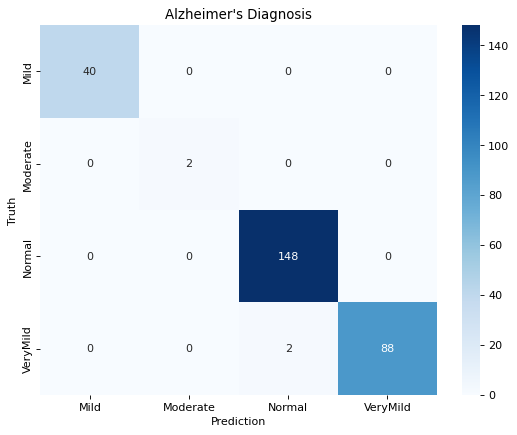

In [15]:
predic = vg_model.predict(test_data)

predic = np.argmax(predic, axis=1)
labels = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(labels, predic)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
ax = sn.heatmap(conf_arr, cmap='Blues', annot=True, fmt='d', xticklabels= ['Mild', 'Moderate', 'Normal', 'VeryMild'],
                yticklabels=['Mild', 'Moderate', 'Normal', 'VeryMild'])
plt.title('Alzheimer\'s Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
# plt.subplots(figsize=(9, 6))
plt.show(ax)

## VGG 19 Model

### Data Normalization, Data segregration (train, validation, test)

In [47]:
image_generator = ImageDataGenerator(rescale=1/255, validation_split=0.2) #shear_range =.25, zoom_range =.2, horizontal_flip = True, rotation_range=20)     


train_dataset = image_generator.flow_from_directory(batch_size=8,
                                                 directory='/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train',
                                                 shuffle=True,
                                                 target_size=(176,208), 
                                                 subset="training",
                                                 class_mode='categorical')

validation_dataset = image_generator.flow_from_directory(batch_size=8,
                                                 directory='/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train',
                                                 shuffle=True,
                                                 target_size=(176,208), 
                                                 subset="validation",
                                                 class_mode='categorical')

image_generator_submission = ImageDataGenerator(rescale=1/255) 
submission = image_generator_submission.flow_from_directory(
                                                 directory='/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test',
                                                 shuffle=False,
                                                 target_size=(176,208), 
                                                 class_mode=None)

Found 4098 images belonging to 4 classes.
Found 1023 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


### Data and label visualization

/opt/conda/lib/python3.7/site-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


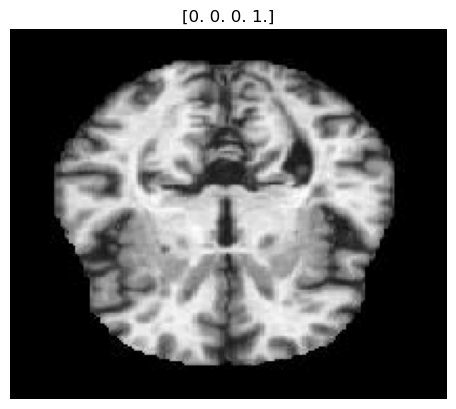

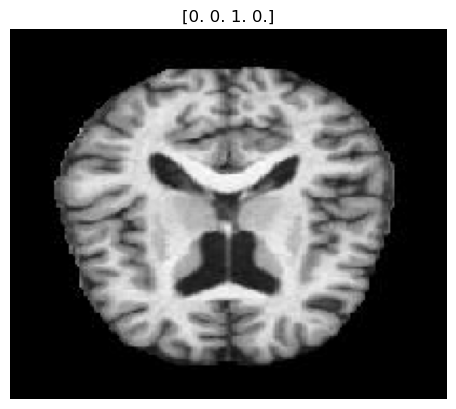

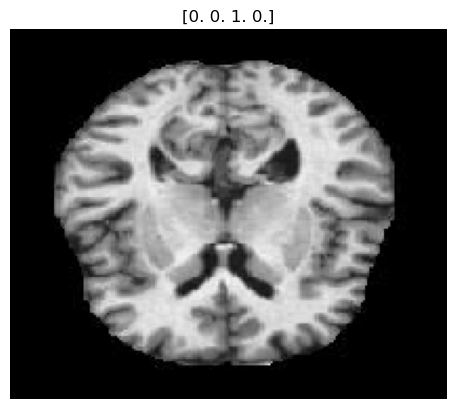

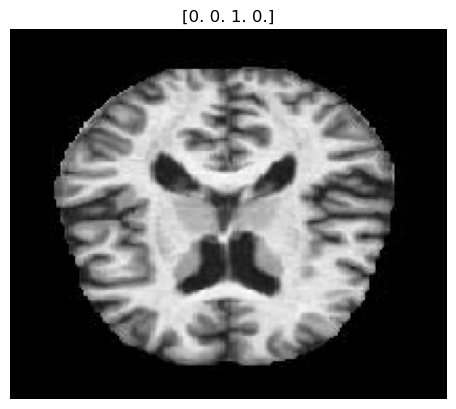

In [19]:
batch_1_img = train_dataset[0]
for i in range(0,4):
    img = batch_1_img[0][i]
    lab = batch_1_img[1][i]
    plt.imshow(img)
    plt.title(lab)
    plt.axis('off')
    plt.show()

### Model Building

In [20]:
vgg = VGG19(input_shape=(176,208,3), weights='imagenet', include_top=False)
for layer in vgg.layers:
    layer.trainable = False
x = Flatten()(vgg.output)

prediction = Dense(4, activation='softmax')(x)

modelvgg = Model(inputs=vgg.input, outputs=prediction)
modelvgg.summary()

80134624/80134624 [==============================] - 3s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 176, 208, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 176, 208, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 176, 208, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 88, 104, 64)       0         
                                                                 
 block2_conv1 (Conv2D)       (None, 88, 104, 128)      73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 88, 104, 128)      147584    
                                                              

### Adding Loss Function, Optimizer and metrics to the model

In [24]:
modelvgg.compile(optimizer='adam',
loss=tf.losses.CategoricalCrossentropy(),
metrics=[keras.metrics.AUC(name='auc')])

### Model Fitting

In [25]:
history = modelvgg.fit(train_dataset, epochs=20, validation_data=validation_dataset)

Epoch 1/20
513/513 [==============================] - 22s 38ms/step - loss: 0.9580 - auc: 0.8572 - val_loss: 1.2184 - val_auc: 0.8086
Epoch 2/20
513/513 [==============================] - 17s 34ms/step - loss: 0.6611 - auc: 0.9240 - val_loss: 1.4204 - val_auc: 0.8073
Epoch 3/20
513/513 [==============================] - 17s 33ms/step - loss: 0.5145 - auc: 0.9521 - val_loss: 0.9706 - val_auc: 0.8424
Epoch 4/20
513/513 [==============================] - 17s 33ms/step - loss: 0.4108 - auc: 0.9690 - val_loss: 1.1812 - val_auc: 0.8215
Epoch 5/20
513/513 [==============================] - 17s 33ms/step - loss: 0.3752 - auc: 0.9743 - val_loss: 1.6250 - val_auc: 0.7964
Epoch 6/20
513/513 [==============================] - 17s 33ms/step - loss: 0.3416 - auc: 0.9785 - val_loss: 0.9848 - val_auc: 0.8650
Epoch 7/20
513/513 [==============================] - 17s 33ms/step - loss: 0.2886 - auc: 0.9849 - val_loss: 1.0508 - val_auc: 0.8569
Epoch 8/20
513/513 [==============================] - 17s 33ms

### Model Metrics

In [44]:
loss, accuracy = modelvgg.evaluate(validation_dataset)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

128/128 [==============================] - 3s 27ms/step - loss: 0.8675 - auc: 0.9052
Loss:  0.8674919605255127
Accuracy:  0.9051650166511536


### Model Evaluation

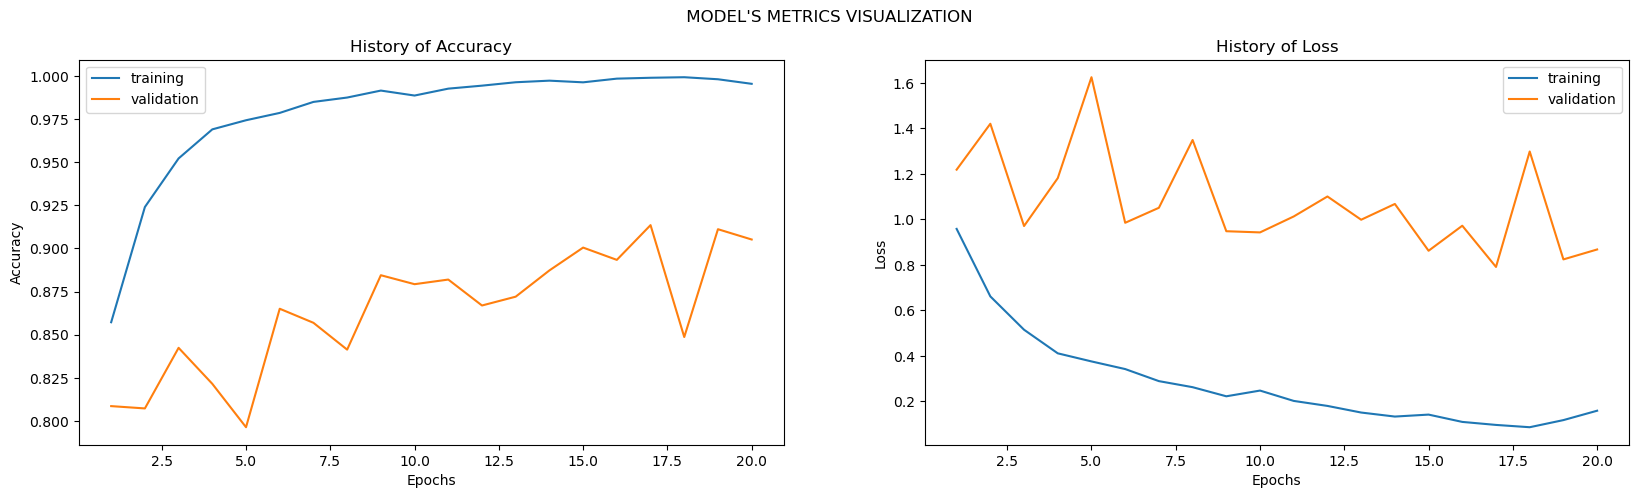

In [43]:
def Train_Val_Plot(acc,val_acc,loss,val_loss):
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    plt.show()
    

Train_Val_Plot(history.history['auc'],history.history['val_auc'],
               history.history['loss'],history.history['val_loss']
              )